##### install yasa

In [1]:
!pip install --upgrade yasa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 136 kB/s 
     |████████████████████████████████| 7.5 MB 22.7 MB/s 
     |████████████████████████████████| 423 kB 43.7 MB/s 
     |████████████████████████████████| 365 kB 19.0 MB/s 
     |████████████████████████████████| 67 kB 3.7 MB/s 
     |████████████████████████████████| 62 kB 937 kB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
     |████████████████████████████████| 1.6 MB 39.0 MB/s 
  Created wheel for yasa: filename=yasa-0.6.2-py3-none-any.whl size=33797167 sha256=27d249c646f9a79a544666fbe11d37b82a1073524a58e4bc979bc28713e29643
  Stored in directory: /root/.cache/pip/wheels/52/8c/9c/1352fced5b6240ed1e3669f477d7ce0e2fe693e28b7bcc45f4
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78033 sha256=8dd1a5de4e775ab3c9f51dbc4ca4e620fab1cb1648eed076661c981e57556cdd
  Stored in directory: /root/

# Brain—body coupling in YASA

This notebook illustrates how to calculate the overnight correlation between brain activity (EEG bandpower) and cardiovascular features (heart rate and HRV).

* Author: Dr. Raphael Vallat (raphaelvallat9@gmail.com)
* Date: July 2022

In [2]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.25)

## Load data

We'll use the polysomnography data from the [YASA quickstart](https://raphaelvallat.com/yasa/build/html/quickstart.html). Make sure to download the EDF and hypnogram files on your computer and then update the `wdir` path.

In [3]:
#구글드라이브 공유폴더에서 불러오기
!gdown --id 1o3rf20v_bbgaMBWKzxj_J3jEx9iLJ-Sw --output 16_yasa_example_night_young.edf

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o3rf20v_bbgaMBWKzxj_J3jEx9iLJ-Sw
To: /content/16_yasa_example_night_young.edf
100% 266M/266M [00:02<00:00, 127MB/s]


In [4]:
# Define paths
# wdir = "/Users/raphael/Drive/yasa_quickstart/"
# path_edf = wdir + "yasa_example_night_young.edf"
# path_hypno = wdir + "yasa_example_night_young_hypno.csv"

path_edf = "/content/16_yasa_example_night_young.edf"
path_hypno = "https://raw.githubusercontent.com/beneyoung/yasa_basic/main/spindle_notebooks/data/16_yasa_example_night_young_hypno.csv"

In [5]:
# Use MNE to load the EDF file
raw = mne.io.read_raw_edf(path_edf, preload=True, verbose=False)
# Keep only one EEG channel (C4-A1) and one ECG
raw.pick_channels(['C4-A1', 'EKG-R-EKG-L'], ordered=True)
raw

<RawEDF | 16_yasa_example_night_young.edf, 2 x 5784000 (28920.0 s), ~88.3 MB, data loaded>

In [6]:
# Extract the EEG and ECG data, in microVolts
eeg, ecg = data = raw.get_data(units="uV")
sf = raw.info["sfreq"]
eeg, ecg, sf

(array([ -69.,  -70.,  -72., ..., -111., -122., -128.]),
 array([27., 27., 26., ...,  4.,  6.,  7.]),
 200.0)

In [7]:
# Load the hypnogram
hypno_orig = pd.read_csv(path_hypno).squeeze("columns")
hypno = yasa.hypno_upsample_to_data(hypno_orig, sf_hypno=1/30, data=raw)
hypno.shape

(5784000,)

## Brain-body coupling on the entire recording

### Calculate cardiovascular features

Using the [yasa.hrv_stage](https://raphaelvallat.com/yasa/build/html/generated/yasa.hrv_stage.html#yasa.hrv_stage) function, we can calculate heart rate and HRV in consecutive epochs of 2.5 minutes throughout the entire night. We get the following columns:

- `start`: the start of the epoch, in seconds from the beginning of the recording
- `duration`: the duration of the epoch, in this case it is always 150 seconds (2.5 min)
- `hr_mean`: the mean heart rate (BPM) in current epoch
- `hr_std`: the standard deviation of the heart rate in current epoch
- `hrv_rmssd`: the HRV in the current epoch. Specifically, the root mean square of successive differences between normal heartbeats (RMSSD). The RMSSD reflects the beat-to-beat variance in heart rate and is the primary time-domain measure used to estimate the vagally mediated changes reflected in HRV ([Shaffer and Ginsberg 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/))

The ECG heartbeat detection is performed with the [sleepecg](https://github.com/cbrnr/sleepecg) package. A minimal outlier rejection is performed, consisting of removing and interpolating inter-beat intervals outside the range of 500 to 1600 ms (37.5 to 120 bpm).

In [8]:
hrv, _ = yasa.hrv_stage(ecg, sf, threshold="2.5min", equal_length=True, rr_limit=(500, 1400))
hrv.head(10).round(4)

start  duration  hr_mean   hr_std  hrv_rmssd
values epoch                                               
0      0         0.0     150.0  56.0484   6.4150    93.0896
       1       150.0     150.0  53.1473   4.4523   117.8534
       2       300.0     150.0  55.8612   9.5444   116.4574
       3       450.0     150.0  60.0265  14.2854   108.0822
       4       600.0     150.0  54.6351   3.3517    89.4281
       5       750.0     150.0  56.2327   4.0530    83.0750
       6       900.0     150.0  54.8637   2.9856    78.8270
       7      1050.0     150.0  53.5248   2.7591    69.1373
       8      1200.0     150.0  53.9280   5.6145    89.6373
       9      1350.0     150.0  51.2966   2.4314    68.1618

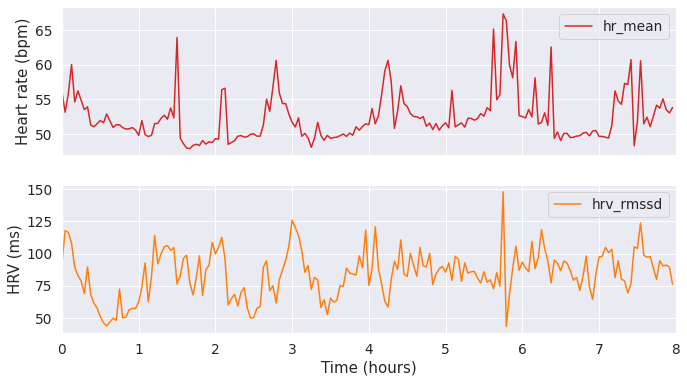

In [9]:
# Plot the HR and HRV across the night
hrv["start_hours"] = hrv["start"] / 3600

ax = hrv.plot(
    x="start_hours", y=["hr_mean", "hrv_rmssd"], subplots=True, figsize=(11, 6), 
    xlabel="Time (hours)", xlim=(0, 8), lw=1.5,
    color=["tab:red", "tab:orange"])

ax[0].set_ylabel("Heart rate (bpm)")
ax[1].set_ylabel("HRV (ms)");

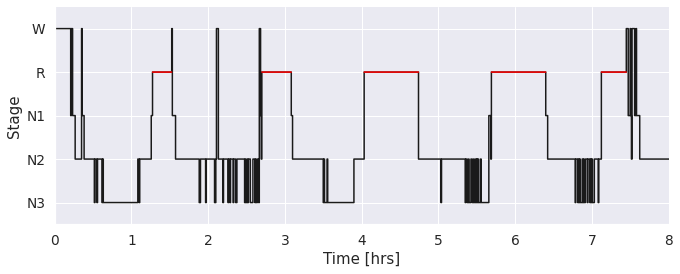

In [10]:
# Plot the hypnogram
ax = yasa.plot_hypnogram(hypno_orig, figsize=(11, 4))
ax.set_xlim(0, 8);

From the plots above, it is pretty clear that heart rate is higher during REM sleep and wakefulness, and lower during NREM sleep. Finding such patterns for HRV is more difficult, but we do see a clear outlier peak around the 6 hours mark. Here, we'll leave it as is, but for an actual project, we would definitely need to remove this outlier.

### Calculate EEG powers

For each of these 2.5-min epochs, we now calculate the corresponding EEG sigma power. While this could be done with a for loop, here we leverage the [yasa.sliding_window](https://raphaelvallat.com/yasa/build/html/generated/yasa.sliding_window.html#yasa.sliding_window) function to convert our continuous EEG data into epochs of 2.5-minutes, and then calculate the bandpower on each epoch. Please see [08_bandpower.ipynb](https://github.com/raphaelvallat/yasa/blob/master/notebooks/08_bandpower.ipynb) for more details on the [yasa.bandpower](https://raphaelvallat.com/yasa/build/html/generated/yasa.bandpower.html#yasa.bandpower) function

In [11]:
t, eeg_2d = yasa.sliding_window(eeg, sf, window=150)
bp = yasa.bandpower(eeg_2d, sf).reset_index(drop=True)
bp.index.name = "epoch"
bp.round(4)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
epoch,,,,,,,,,
0,0.4470,0.1874,0.2946,0.0265,0.0369,0.0077,132.5558,0.25,True
1,0.3679,0.2311,0.3485,0.0230,0.0243,0.0053,147.9583,0.25,True
2,0.3451,0.2030,0.3756,0.0339,0.0363,0.0062,105.6220,0.25,True
3,0.2767,0.1100,0.3555,0.0599,0.1346,0.0633,191.2137,0.25,True
4,0.3916,0.1547,0.3799,0.0260,0.0386,0.0092,123.5907,0.25,True
...,...,...,...,...,...,...,...,...,...
187,0.6694,0.2514,0.0435,0.0153,0.0173,0.0031,96.1594,0.25,True
188,0.7061,0.2106,0.0470,0.0153,0.0172,0.0037,102.2158,0.25,True
189,0.7321,0.1930,0.0422,0.0154,0.0146,0.0028,115.5555,0.25,True


In [12]:
# Combine with the HRV dataframe. We'll focus on the delta and sigma power.
hrv["sigma"] = bp["Sigma"].to_numpy()
hrv["delta"] = bp["Delta"].to_numpy()

hrv.head().round(3)

start  duration  hr_mean  hr_std  hrv_rmssd  start_hours  sigma  \
values epoch                                                                    
0      0        0.0     150.0   56.048   6.415     93.090        0.000  0.026   
       1      150.0     150.0   53.147   4.452    117.853        0.042  0.023   
       2      300.0     150.0   55.861   9.544    116.457        0.083  0.034   
       3      450.0     150.0   60.026  14.285    108.082        0.125  0.060   
       4      600.0     150.0   54.635   3.352     89.428        0.167  0.026   

              delta  
values epoch         
0      0      0.447  
       1      0.368  
       2      0.345  
       3      0.277  
       4      0.392

### Calculate EEG-HRV correlations

We can now run some correlations between the cardiovascular features and the EEG bandpower.

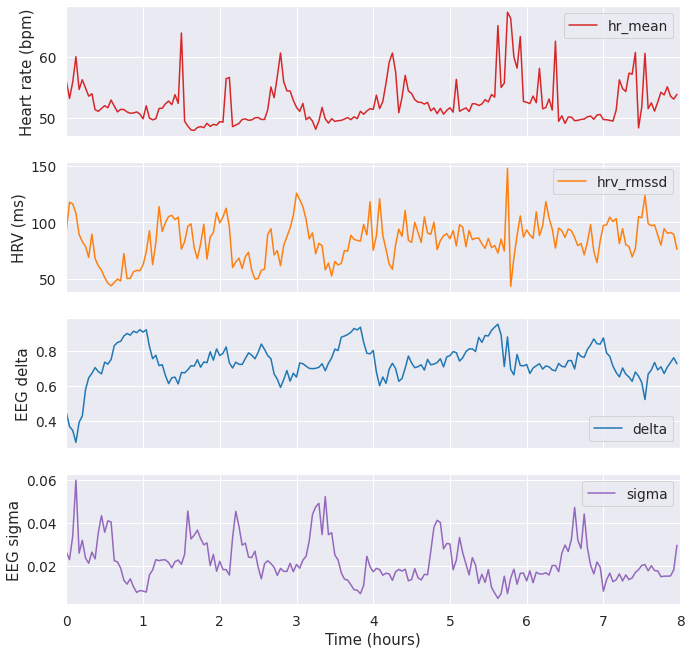

In [13]:
# Plot the EEG delta and sigma power across the night (as well as HR and HRV)
ax = hrv.plot(
    x="start_hours", y=["hr_mean", "hrv_rmssd", "delta", "sigma"], subplots=True, figsize=(11, 11), 
    xlabel="Time (hours)", xlim=(0, 8), lw=1.5,
    color=["tab:red", "tab:orange", "tab:blue", "tab:purple"])

ax[0].set_ylabel("Heart rate (bpm)")
ax[1].set_ylabel("HRV (ms)");
ax[2].set_ylabel("EEG delta");
ax[3].set_ylabel("EEG sigma");

In [14]:
# Calculate Spearman correlations
hrv[["hr_mean", "hrv_rmssd", "delta", "sigma"]].corr(method="spearman").round(3).iloc[:2]

,hr_mean,hrv_rmssd,delta,sigma
hr_mean,1.000,0.113,-0.366,-0.346
hrv_rmssd,0.113,1.000,-0.285,-0.062


**Some conclusions:**

- There is a negative correlation between heart rate and both delta and sigma power. This makes sense since heart rate is typically lower in NREM sleep when delta and sigma power are high. Conversely, heart rate is high during wakefulness, while delta and sigma power are low.
- HRV is also negatively correlated with delta, but not really with sigma. This would suggest that high HRV occurs during periods of deep NREM sleep, when delta power is at is maximum. Conversely, HRV should be lower during wakefulness or REM sleep, when delta power is reduced.

********

## For NREM and REM separately

In [15]:
# Merge N2 and N3 into NREM sleep
hypno[hypno == 3] = 2
np.unique(hypno)

array([0, 1, 2, 4])

### Calculate cardiovascular features

In [16]:
# Pass the hypnogram and apply separately for NREM and REM
hrv, _ = yasa.hrv_stage(
    ecg, sf, hypno=hypno, include=(2, 4), threshold="2.5min", equal_length=True, rr_limit=(500, 1400))

print(f"{hrv.xs(2).shape[0]} epochs of NREM sleep were found")
print(f"{hrv.xs(4).shape[0]} epochs of REM sleep were found")
hrv.round(3)

116 epochs of NREM sleep were found
56 epochs of REM sleep were found


start  duration  hr_mean  hr_std  hrv_rmssd
values epoch                                               
2      0        990.0     150.0   53.325   2.580     66.723
       1       1140.0     150.0   53.358   3.493     84.776
       2       1410.0     150.0   51.272   2.237     65.858
       3       1560.0     150.0   50.995   2.160     60.188
       4       1710.0     150.0   51.702   1.896     48.782
...               ...       ...      ...     ...        ...
4      51     25980.0     150.0   57.219   5.084     88.565
       52     26130.0     150.0   54.266   5.150     97.766
       53     26280.0     150.0   55.157   4.350     79.374
       54     26430.0     150.0   57.144   4.550     71.559
       55     26580.0     150.0   56.644   4.255     70.416

[172 rows x 5 columns]

### Calculate EEG powers

Let's use a good old _for loop_ here.

In [17]:
# Initialize empty columns
hrv["delta"] = np.nan
hrv["theta"] = np.nan
hrv["alpha"] = np.nan
hrv["sigma"] = np.nan


# Loop across each epoch
for idx, row in hrv.iterrows():
    # Find indices (in samples) of start and end of epoch
    start = int(row["start"] * sf)
    end = int(sf * (row["start"] + row["duration"]))
    # Calculate bandpower
    bp = yasa.bandpower(eeg[start:end], sf)
    # Add to DataFrame
    hrv.loc[idx, "delta"] = bp["Delta"].iloc[0]
    hrv.loc[idx, "theta"] = bp["Theta"].iloc[0]
    hrv.loc[idx, "alpha"] = bp["Alpha"].iloc[0]
    hrv.loc[idx, "sigma"] = bp["Sigma"].iloc[0]
    
hrv.round(3)

start  duration  hr_mean  hr_std  hrv_rmssd  delta  theta  \
values epoch                                                                
2      0        990.0     150.0   53.325   2.580     66.723  0.632  0.272   
       1       1140.0     150.0   53.358   3.493     84.776  0.674  0.226   
       2       1410.0     150.0   51.272   2.237     65.858  0.698  0.188   
       3       1560.0     150.0   50.995   2.160     60.188  0.670  0.211   
       4       1710.0     150.0   51.702   1.896     48.782  0.708  0.181   
...               ...       ...      ...     ...        ...    ...    ...   
4      51     25980.0     150.0   57.219   5.084     88.565  0.651  0.257   
       52     26130.0     150.0   54.266   5.150     97.766  0.682  0.235   
       53     26280.0     150.0   55.157   4.350     79.374  0.666  0.250   
       54     26430.0     150.0   57.144   4.550     71.559  0.655  0.260   
       55     26580.0     150.0   56.644   4.255     70.416  0.648  0.260   

              alpha  sigma  
values epoch                
2      0      0.045  0.021  
       1      0.050  0.022  
       2      0.055  0.028  
       3      0.058  0.037  
       4      0.055  0.044  
...             ...    ...  
4      51     0.052  0.016  
       52     0.047  0.015  
       53     0.046  0.015  
       54     0.048  0.014  
       55     0.054  0.014  

[172 rows x 9 columns]

### Calculate EEG-HRV correlations

In [18]:
# Correlation in NREM sleep
cols = ["hr_mean", "hrv_rmssd", "delta", "theta", "alpha", "sigma"]
hrv.xs(2)[cols].corr(method="spearman").round(2).iloc[:2]

,hr_mean,hrv_rmssd,delta,theta,alpha,sigma
hr_mean,1.00,0.05,0.13,-0.08,-0.24,-0.34
hrv_rmssd,0.05,1.00,-0.14,0.18,0.14,-0.07


In [19]:
# Correlation in REM sleep
hrv.xs(4)[cols].corr(method="spearman").round(2).iloc[:2]

,hr_mean,hrv_rmssd,delta,theta,alpha,sigma
hr_mean,1.00,-0.55,0.11,-0.13,-0.14,-0.15
hrv_rmssd,-0.55,1.00,-0.02,-0.07,0.15,0.30


**Some conclusions:**

- Overall the correlations between HRV and EEG are weaker when considering stage-specific associations instead of the entire night. This is likely because we removed the strong effect of wakefulness.
- In NREM sleep, sigma power is the strongest predictor of heart rate. Specifically, higher sigma power is associated with lower heart rate. The strongest predictor of HRV is theta power, with higher theta predicting higher HRV (a good outcome).
- In REM sleep, sigma power is the strongest predictor of both heart rate and HRV. Here, higher sigma is associated with a lower heart rate and a higher HRV, i.e. more restorative sleep. This is perhaps surprising since the sigma band is not typically associated with REM sleep.

There are many other ways that we could leverage YASA to calculate brain—body coupling. For example, [Mikutta et al 2021](https://onlinelibrary.wiley.com/doi/10.1111/jsr.13466) showed a correlation between slow oscillations—spindle coupling (and phase) and heart rate variability in NREM sleep. Also, changing some of the parameters of this analysis — such as the epoch length or the outlier rejection thresholds — may strongly impact the results. On the latter, the [yasa.hrv_stage](https://raphaelvallat.com/yasa/build/html/generated/yasa.hrv_stage.html#yasa.hrv_stage) function also returns the indices of all the detected ECG peaks, so we could easily apply a different outlier rejection method and/or calculate other relevant HRV metrics.